# An Analysis of Linear and Non-Linear Mass - Damper Systems  
# First Order Systems 
# Harmonic Balance vs. Time Integration 

Here we study the harmonic balance method and time integration applied to the ODE 

$$
m \, \dot{u}(t) + \gamma_1 \, u(t) + \gamma_3 \, u^3(t) = F_0 \, \sin(k \, \omega_e \, t) \, . 
$$

## Import Libraries

In [1]:
using LinearAlgebra
using DifferentialEquations
using FFTW

using BenchmarkTools

using Plots 

## To do 

1. Improve type-setting for numerical values for A and B for 3 damping cases. Add a caption to the table; 
2. Document values obtained graphically for A and B for the non-linear model further (increasing values for damping pushes values for A and B towards 0);
3. Document results obtained using FFT. Highlight occurance of the third order harmonic. Speculate on extension to find both first and third order harmonic; 
4. Extend implementation of first coupled equations; 
5. Use [FourierFlows.jl](https://fourierflows.github.io/FourierFlowsDocumentation/stable/) to construct example for shallow water equations with periodic forcing. FourierFlows use periodic boundary conditions by default; 
6. Explore alternative implementation in which: (a) the harmonic balance solution is stored as an array of structs of length $2\,Nh+2$, each struct holding the amplitude of the Fourier modes $C_i$ and $S_i$, angular frequency (and possibly other data) (b) a time-derivative can operate on the struct to obtain a new struct of the same type (double time derivative only feasible) (c) defines the non-linear operation on the struct in terms of a convolution. The higher order powers in sin and cos will have to expanded in higher order harmonics. Bookkeeping on the resulting amplitudes will have to be performe (d) defines the residual vector as difference between curent state and desired state. Defines non-linear least-squares functional of a sum of squares of components of the residual vecctor. (e) defines Jacobian of least-squares functional wrt the amplitudes of the cos and sin modes using automatic differentiation (f) solves the non-linear system by a Newton iteration. Does using [symbolics.jl](https://symbolics.juliasymbolics.org/stable/) help in solving these questions? 

## Section 1: Introduction 

Here we wish to apply the harmonic balance method apply the harmonic balance method to a first order scalar ordinary differential equation. We consider the scalar ordinary differential equation for the velocity $u(t)$ of a point with mass $m$ (unit kg) attached to a damper with linear damping constant $\gamma$ (unit kg/s). We consider the external sinusoidal forcing $F_e(t)$ with amplitude $F_0$ and angular frequency equal to an integer $k$ multiple of $\omega_e$. We will study a linear and non-linear case. In the non-linear case, we will assume damping to be cubic in the velocity $u$.  

In the linear case, we compare harmonic balance with the analytical solution and with time-integration. We observe that the harmonic balance method recovers the analytical solution after an initial time period in which initial transients disappear.      

### Linear Model 

In the linear case, Newton's Third Law of motion $F = m \, a$ in terms of the velocity can then be written as $m \, \dot{u}(t) + \gamma_1 \, u(t) = F_e(t) = F_0 \, \sin(k \, \omega_e \, t)$ (we deliberately distinguish the angular frequency $\omega_e$ of the driving force from the eigen angular frequency $\omega_0 = \sqrt{ \frac{k}{m} }$ that we will introduce later). We assume an initial velocity given by $u_0$. 

### Non-Linear Model 

We will consider the non-linear model in which the damping is extended with a cubic damping term $m \, \dot{u}(t) + \gamma_1 \, u(t) + \gamma_3 \, u^3(t) = F_0 \, \sin(k \, \omega_e \, t)$ supplied with the initial condition $u_0$. Note that we consider the non-linear damping to add to the previous defined linear damping. 

### Linear Model without External Forcing 

In case of no external damping, or $F_0 = 0$, the linear model reduces to $m \, \dot{u}(t) + \gamma_1 \, u(t) = 0$ or $\dot{u}(t) + \frac{ \gamma_1 } {m} \, u(t) = 0$. The constant $\tau_1 = \frac{m}{ \gamma_1 }$ (unit s) is the characteristic time scale of motion returning to equilibrium state. The equation can be written as $\dot{u}(t) + \frac{ 1 } {\tau_1} \, u(t) = 0$. The analytical solution $u^a(t)$ is given by 
$u^a(t) = u_0 \, \exp( - t / \tau_1 )$. Larger $\tau_1$ (either larger $m$ or smaller $\gamma_1$) implies slower motion towards equilibrium state. 

### Linear Model with Sinusoidal External Forcing: Analytical Solution 

In case of sinusoidal external forcing using $F_e(t) = F_0 \, \sin(k \, \omega_e \, t)$, a closed form expression for the solution can be found analytically. Link to notebook using sympy here. The analytical consists of two terms. The first term vanishes exponentially. The second term is a sum of sinus and cosinus terms with the same frequency as the driving force. 

### Linear Model with Sinusoidal External Forcing: Harmonic Balancing 

In case of sinusoidal external forcing, we set the harmonic balancing solution $u^{hb}(t) = A \, \sin(k \, \omega_e \, t) + B \, \cos(k \, \omega_e \, t)$. We then have that $\dot{u}^{hb}(t) = (k \, \omega_e) \, A \, \cos(k \, \omega_e \, t) - ( k \, \omega_e) \, B \, \sin(k \, \omega_e \, t) $. The ODE $\dot{u}^{hb}(t) + \frac{ 1 } {\tau_1} \, u^{hb}(t) =  F_0 \, \sin(k \, \omega_e \, t)$ then becomes   $ [ (k \, \omega_e) \, A + \frac{ 1 } {\tau_1} \, B] \, \cos(k \, \omega_e \, t) + [ \frac{ 1 } {\tau_1} \, A - ( k \, \omega_e) \, B ] \, \sin(k \, \omega_e \, t) =  F_0 \, \sin(k \, \omega_e \, t) $. We thus obtain the following linear system for the coefficients $A$ and $B$: 

$   (k \, \omega_e) \, A + \frac{ 1 } {\tau_1} \, B = 0 \\ 
    \frac{ 1 } {\tau_1} \, A - (k \, \omega_e) \, B = F_0 $  
  
with solution $ A = \frac{F_0}{\tau_1 \, [(k \, \omega_e)^2 + \frac{ 1 } {\tau_1^2}]}$ and $ B = \frac{- (k \, \omega_e) \, F_0}{(k \, \omega_e)^2 + \frac{ 1 } {\tau_1^2}}$. We have that $\sqrt{A^2 + B^2} = \frac{ F_0 }{(k \, \omega_e)^2 + \frac{ 1 } {\tau_1^2}}$.  

The harmonic balance solution $u^{hb}(t)$ is thus given by 
$u^{hb}(t) = A \, \sin(k \, \omega_e \, t) + B \, \cos(k \, \omega_e \, t)$. In the linear case, the harmonic balance solution is an **exact** solution for $t>t^*$, where $t^*$ is the time instance in which the exponential term in the exact has become sufficiently small. 

|$\tau$    |A         |         B|
|:--------:|:--------:|:--------:|
|0.1       | 0.098    | -0.012   | 
|1         | 0.387    | -0.487   |
|10        | 0.063    | -0.790   | 
  
### Non-Linear Model without External Forcing 

In case of no external damping, the non-linear model reduces to $m \, \dot{u}(t) + \gamma_1 \, u(t) + \gamma_3 \, u^3(t) = 0$ or $\dot{u}(t) + \frac{ \gamma_1 }{m} \, u(t) + \frac{ \gamma_3 }{m} \, u^3(t) = 0$. Given that this equation is seperable, we obtain $ - du / [ \frac{ \gamma_1 }{m} \, u(t) + \frac{ \gamma_3 }{m} \, u^3(t) ] = dt$. We imagine that a solution for $u(t)$ in closed form can be found.  

### Non-Linear Model with Sinusoidal External Forcing: Time Integration 

We use time integration to obtain a reference solution for the non-linear model.  

### Non-Linear Model with Sinusoidal External Forcing: Harmonic Balancing 

Substituting the form of the solution $u^{hb}(t) = A \, \sin(k \, \omega_e \, t) + B \, \cos(k \, \omega_e \, t)$ into the ODE $m \, \dot{u}(t) + \gamma_1 \, u(t) + \gamma_3 \, u^3(t) = F_0 \, \sin(k \, \omega_e \, t)$, expanding the non-linear terms into harmonics, neglecting higher order harmonics and rearranging term, we obtain the following polynomial equations for the amplitudes $A$ and $B$ 

$   (k \, \omega_e) \, A + \frac{ 1 } {\tau_1} \, B + \frac{1}{\tau_3} [ \frac{3}{4} B^3 + \frac{3}{4} A^2 \, B] = 0 \\ 
    \frac{ 1 } {\tau_1} \, A - (k \, \omega_e) \, B + \frac{1}{\tau_3} [ \frac{3}{4} A^3 + \frac{3}{4} A \, B^2 ] = F_0 $

### Open Questions 

1. In which scenarios is the third harmonic harmonic? 
2. In which scenarios is the single-harmonic harmonic balancing scenarios accurate? Stated differently, in which scenarios is a two-harmonic harmonic balancing solution required? 

### Structure of This Notebook 

This notebook is structured as follows. In Section 2, we consider the case of no external forcing, or $F_0 = 0$. More ...  

## Section 2: Linear Model without External Forcing 
Here we consider the case of no external forcing. We investigate how the solution depends on the characteristic time $\tau$.   

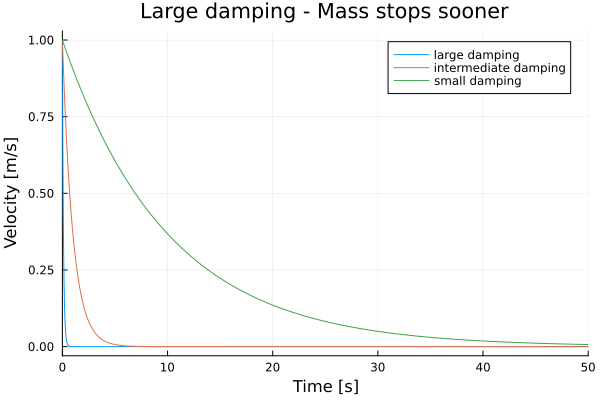

In [2]:
# set characteristic time constant (tau)
tauOne1 = 0.1
tauOne2 = 1
tauOne3 = 10
p = [tauOne1, tauOne2, tauOne3] 

function ode!(du,u,p,t)
    du[1] = -(1/p[1])*u[1]
    du[2] = -(1/p[2])*u[2]
    du[3] = -(1/p[3])*u[3]
end

u0 = [1., 1., 1.] # initial condition
# u0 = [-1., -1., -1.] # initial condition
tspan = (0.0,50.0) # time span

prob = ODEProblem(ode!,u0,tspan,p)

sol = solve(prob, AutoVern7(Rodas5()))

plot(sol,idxs=1,label="large damping")
plot!(sol,idxs=2,label="intermediate damping")
plot!(sol,idxs=3,label="small damping", title="Large damping - Mass stops sooner", xlabel="Time [s]", ylabel="Velocity [m/s]") 

## Section 3: Linear Model With External Sinusoidal Forcing: Harmonic Balance Method  

In [3]:
# solve linear system for the amplitudes A and B of the harmonic balance solution 
# A: amplitude of the sin(k omega t) term 
# B: amplitude of the cos(k omega t) term
function solveLinearSystem(Fnul,k,omega_e,tau1)
    D  = (k*omega_e)^2 + 1 / tau1^2 
    D1 = Fnul/tau1
    D2 = -(k*omega_e)*Fnul  
    A  = D1/D 
    B  = D2/D 
    return A, B
end

solveLinearSystem (generic function with 1 method)

In [4]:
function generateHBSolution(t,Fnul,k,omega_e,tau1)
    A, B = solveLinearSystem(Fnul,k,omega_e,tau1)  
    return A*sin(k*omega_e*t) + B*cos(k*omega_e*t)
end 

generateHBSolution (generic function with 1 method)

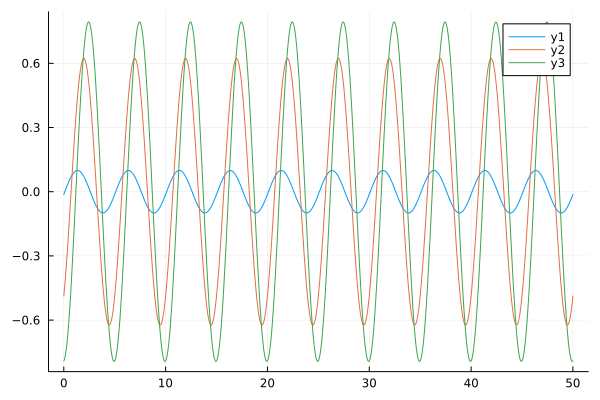

In [5]:
Tend = 50; Nt = 1000; dt = Tend/Nt; 
tvec = Vector(0:dt:Tend);

Fnul = 1.; k = 1; freq_e = .2; omega_e = 2*π*freq_e; 

tauOne1 = 0.1; 
tauOne2 = 1; 
tauOne3 = 10; 

A1, B1 = solveLinearSystem(Fnul,k,omega_e,tauOne1)
#display(A1); display(B1)
A2, B2 = solveLinearSystem(Fnul,k,omega_e,tauOne2)
#display(A2); display(B2)
A3, B3 = solveLinearSystem(Fnul,k,omega_e,tauOne3)
#display(A3); display(B3)

xhb1 = generateHBSolution.(tvec,Fnul,k,omega_e,tauOne1)
xhb2 = generateHBSolution.(tvec,Fnul,k,omega_e,tauOne2)
xhb3 = generateHBSolution.(tvec,Fnul,k,omega_e,tauOne3)

plot(tvec, xhb1)
plot!(tvec, xhb2)
plot!(tvec, xhb3)

## Section 4: Linear Model With External Sinusoidal Forcing: Time Integration 
Can steady state be recovered by harmonic balancing? Is the harmonic balance solution here merely the particular solution of the equation assuming $u_p(t) = A \, \cos(\omega_e \, t) + B \, \sin(\omega_e \, t)$? 

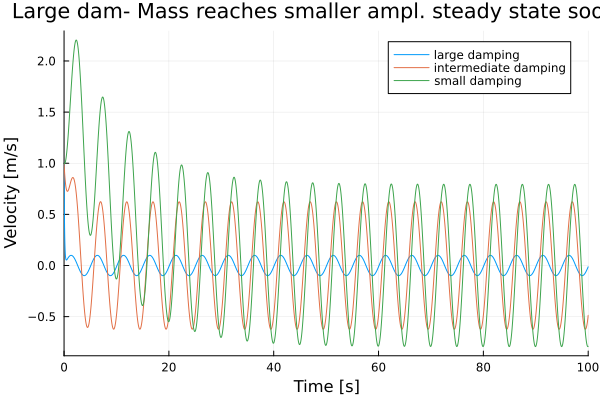

In [6]:
# set characteristic time constant (tau)
tauOne1 = 0.1
tauOne2 = 1
tauOne3 = 10
p = [tauOne1, tauOne2, tauOne3] 

# set driving frequency ()
freq = .2
ω_e = 2 * π * freq 

function ode!(du,u,p,t)
    du[1] = -(1/p[1])*u[1] + sin(ω_e*t)
    du[2] = -(1/p[2])*u[2] + sin(ω_e*t)
    du[3] = -(1/p[3])*u[3] + sin(ω_e*t) 
end

u0 = [1., 1., 1.] # initial condition
# u0 = [-1., -1., -1.] # initial condition
tspan = (0.0,100.0) # time span

prob = ODEProblem(ode!,u0,tspan,p)

sol = solve(prob, AutoVern7(Rodas5()))

plot(sol,idxs=1,label="large damping") 
plot!(sol,idxs=2,label="intermediate damping")
plot!(sol,idxs=3,label="small damping", title="Large dam- Mass reaches smaller ampl. steady state sooner", xlabel="Time [s]", ylabel="Velocity [m/s]") 

## Section 5: Non-Linear Model Without External Forcing: Time Integration

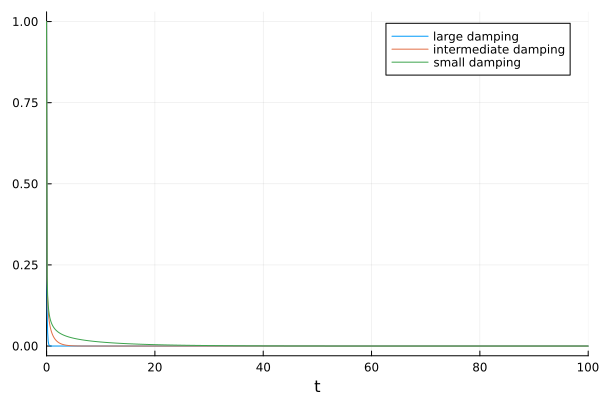

In [7]:
# set characteristic time constant (tau)
tauOne1 = 0.1
tauOne2 = 1
tauOne3 = 10
p = [tauOne1, tauOne2, tauOne3] 

function ode!(du,u,p,t)
    tauThree = 0.01
    du[1] = -(1/p[1])*u[1] - 1/tauThree*u[1]^3 
    du[2] = -(1/p[2])*u[2] - 1/tauThree*u[2]^3 
    du[3] = -(1/p[3])*u[3] - 1/tauThree*u[3]^3      
end

u0 = [1., 1., 1.] # initial condition
# u0 = [-1., -1., -1.] # initial condition
Tend = 100
tspan = (0.0,Tend) # time span

prob = ODEProblem(ode!,u0,tspan,p)

sol = solve(prob, AutoVern7(Rodas5()))

plot(sol,idxs=1,label="large damping") 
plot!(sol,idxs=2,label="intermediate damping")
plot!(sol,idxs=3,label="small damping")

## Section 6: Non-Linear Model With External Sinusoidal Forcing: Harmonic Balancing

In [8]:
# non-linear function whose root defines the harmonic balance solution for A and B 
# A: amplitude of the sin(k omega t) term 
# B: amplitude of the cos(k omega t) term
function generateNLinFunctional(A,B,Fnul,k,omega_e,tau1,tau3)
    F = zeros(2)
    F[1] = (k*omega_e)*A + (1/tau1)*B     + 1/tau3*(3/4*B^3 + 3/4*A^2*B)
    F[2] = (1/tau1)*A     - (k*omega_e)*B + 1/tau3*(3/4*A^3 + 3/4*A*B^2) - Fnul 
    # F[1] = (k*omega_e)*A + (1/tau1)*B     
    # F[2] = (1/tau1)*A     - (k*omega_e)*B - Fnul 
    return norm(F)  
end

generateNLinFunctional (generic function with 1 method)

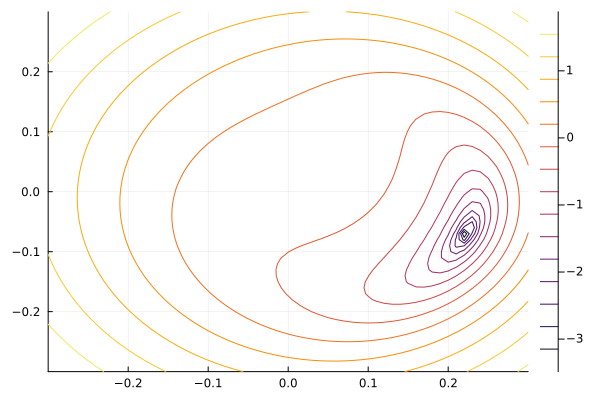

In [9]:
# solve the non-linear problem graphically - as first step - prior to doing anything else   
Fnul = 1.; k = 1; freq_e = .2; omega_e = 2*π*freq_e; 

tauOne1 = 0.1; 
tauOne2 = 1; 
tauOne3 = 10; 

# generate data to solve non-linear problem graphically 
Ast1, Bst1 = solveLinearSystem(Fnul,k,omega_e,tauOne1)
A1lb = Ast1/100; A1ub = Ast1*10; A1vec = Vector(A1lb:(A1ub - A1lb)/100:A1ub)
B1lb = Bst1/100; B1ub = Bst1*10; B1vec = Vector(B1ub:(B1lb - B1ub)/500:B1lb) # ad-hoc fix 
A1vec = Vector(-.3:1/100:.3)
B1vec = Vector(-.3:1/100:.3)
A1grid = repeat(reshape(A1vec, 1,:), length(B1vec), 1);
B1grid = repeat(B1vec, 1, length(A1vec))
data1 = generateNLinFunctional.(A1grid,B1grid,Fnul,k,omega_e,100,0.01)
p1 = contour(A1vec,B1vec,log.(data1))

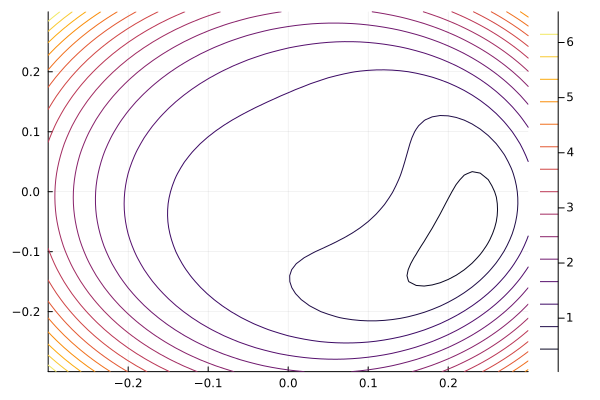

In [10]:
contour(A1vec, B1vec, data1)

## Section 7: Non-Linear Model With External Sinusoidal Forcing: Time Integration 

### Varying the linear damping coefficient 

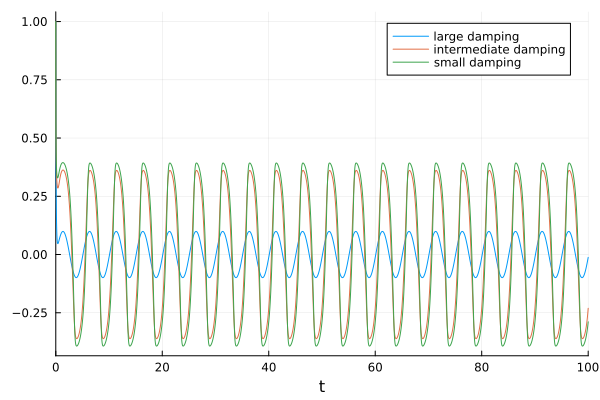

In [11]:
# set characteristic time constant (tau)
tau1 = 0.1
tau2 = 1
tau3 = 10
p = [tau1, tau2, tau3] 

# set driving frequency ()
freq = .2
ω_e = 2 * π * freq 

function ode!(du,u,p,t)
    tauThree = 0.01
    du[1] = -(1/p[1])*u[1] - 1/tauThree*u[1]^5 + sin(ω_e*t)
    du[2] = -(1/p[2])*u[2] - 1/tauThree*u[2]^5 + sin(ω_e*t)
    du[3] = -(1/p[3])*u[3] - 1/tauThree*u[3]^5 + sin(ω_e*t)     
end

u0 = [1., 1., 1.] # initial condition
# u0 = [-1., -1., -1.] # initial condition
Tend = 100
tspan = (0.0,Tend) # time span

prob = ODEProblem(ode!,u0,tspan,p)

sol = solve(prob, AutoVern7(Rodas5()))

plot(sol,idxs=1,label="large damping") 
plot!(sol,idxs=2,label="intermediate damping")
plot!(sol,idxs=3,label="small damping")

### Varying the non-linear damping coefficient 
When does the third harmonic become dominant? 

In [12]:
# set characteristic time constant (tau)
#tauOne = 100
tauThree1 = 0.0001
tauThree2 = 0.01
tauThree3 = 10000 
p = [tauThree1, tauThree2, tauThree3] 

# set driving frequency ()
freq = .2
ω_e = 2 * π * freq 

function ode!(du,u,p,t)
    du[1] = -(1/tauOne)*u[1] - 1/p[1]*u[1]^3 + sin(ω_e*t)
    du[2] = -(1/tauOne)*u[2] - 1/p[2]*u[2]^3 + sin(ω_e*t)
    du[3] = -(1/tauOne)*u[3] - 1/p[3]*u[3]^3 + sin(ω_e*t)     
end

u0 = [1., 1., 1.] # initial condition
# u0 = [-1., -1., -1.] # initial condition
Tend = 100
tspan = (0.0,Tend) # time span

prob = ODEProblem(ode!,u0,tspan,p)

sol = solve(prob, AutoVern7(Rodas5()))

plot(sol,idxs=1,label="large damping") 
plot!(sol,idxs=2,label="intermediate damping")
plot!(sol,idxs=3,label="small damping")

LoadError: UndefVarError: tauOne not defined

## Section 8: Spectral Analysis of Time-Integrated Solution (requires editting)

What is the amplide of the harmonics **not** coinciding with the driving harmonics? 

In [13]:
u1 = sol[1,:]
u2 = sol[2,:]
u3 = sol[3,:]

# perform FFT of sampled position data 
uf1 = fft(u1)
uf2 = fft(u2)
uf3 = fft(u3)

# set number of elements in space, the number of time samples and number of modes 
Nt = 1000; dt = Tend/Nt; 
t = Vector(0:dt:Tend);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nt
fvec = Vector(0:fstep:fmax)

#..plot absolute value of FFT samples  
p1 = plot(fvec, 2.0/Nt * abs.(uf1[1:length(fvec)]),label="norm")
p2 = plot(fvec, angle.(uf1[1:length(fvec)]),label="phase")
p3 = plot(fvec, 2.0/Nt * abs.(uf2[1:length(fvec)]),label="norm")
p4 = plot(fvec, angle.(uf2[1:length(fvec)]),label="phase")
p5 = plot(fvec, 2.0/Nt * abs.(uf3[1:length(fvec)]),label="norm")
p6 = plot(fvec, angle.(uf3[1:length(fvec)]),label="phase")
plot(p1, p2,p3, p4, p5, p6, layout=(3,2)) 

LoadError: BoundsError: attempt to access 491-element Vector{ComplexF64} at index [1:501]

In [156]:
length(fvec)

501

In [157]:
length(uf3)

491